<h3>Multi Level Perceptron: Diabetes Dataset

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

<h5>Basic Data Understanding + Null Value Removal:

In [85]:
data = pd.read_csv('Diabetes-Classification.csv')
data.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,45,Male,25.0,Normal,100,5.7,No,No,Healthy,Regular,No
1,55,Female,30.0,High,120,6.4,Yes,Yes,Poor,No,Yes
2,65,Male,35.0,High,140,7.1,Yes,Yes,Poor,No,Yes
3,75,Female,40.0,High,160,7.8,Yes,Yes,Poor,No,Yes
4,40,Male,20.0,Normal,80,5.0,No,No,Healthy,NaN,No


In [86]:
print(data.isnull().sum())

Age                           0
Gender                        0
BMI                           3
Blood Pressure                0
FBS                           0
HbA1c                         0
Family History of Diabetes    2
Smoking                       2
Diet                          2
Exercise                      1
Diagnosis                     0
dtype: int64


In [87]:
data = data.dropna()

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 0 to 127
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         118 non-null    int64  
 1   Gender                      118 non-null    object 
 2   BMI                         118 non-null    float64
 3   Blood Pressure              118 non-null    object 
 4   FBS                         118 non-null    int64  
 5   HbA1c                       118 non-null    float64
 6   Family History of Diabetes  118 non-null    object 
 7   Smoking                     118 non-null    object 
 8   Diet                        118 non-null    object 
 9   Exercise                    118 non-null    object 
 10  Diagnosis                   118 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 11.1+ KB


<h5>Pre-processing Data:

In [89]:
# Preprocessing the data:
# 1) Separate the numerical and categorical columns (and the target column)
numerical_columns = ['Age', 'BMI', 'FBS', 'HbA1c']
categorical_columns = ['Gender', 
                       'Blood Pressure', 
                       'Family History of Diabetes', 
                       'Smoking', 
                       'Diet', 
                       'Exercise'
                       ]
target_column = 'Diagnosis'

# Standard scaling of numerical columns and one-hot encoding of the categorical

# 2) Take out the target column + split into training and test sets:

x = data.drop(target_column, axis=1)
y = data[target_column]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13, stratify=y)
# Use stratify = y to deal with class imbalance.

# 3) Create transformer + apply:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

transformer = ColumnTransformer(transformers=[
    ('num',StandardScaler(),numerical_columns),
    ('col',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
])

X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.transform(X_test)

y_train = y_train.map({'No': 0, 'Yes': 1}).values
y_test = y_test.map({'No': 0, 'Yes': 1}).values

# 4) Convert X columns Pandas.df -> np.array (For TensorFlow purposes)

X_train_scaled_a = X_train_scaled.astype('float32')
X_test_scaled_a = X_test_scaled.astype('float32')

<h5>MLP Models (TensorFlow):

In [90]:
# Make sure a virtual environment (.venv) is selected (with the appropriate DS packages installed) for TensorFlow to work.

# General TensorFlow:
import tensorflow as tf

# TensorFlow layers:
from tensorflow.keras import layers

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

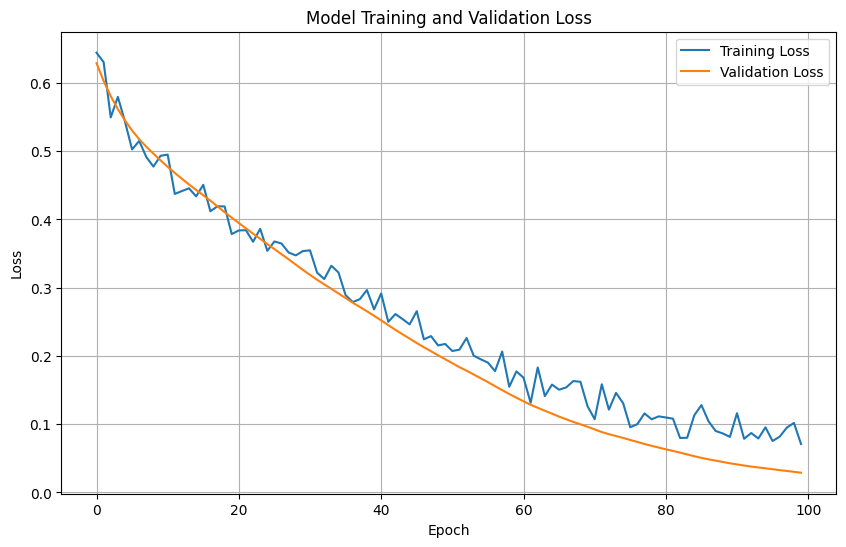

In [91]:
# Building + Compiling the MLP:

model = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled_a.shape[1],)), #17 columns = 17 inputs.
    layers.Dense(64, activation="relu"), # Different activation functions for different layers
    layers.Dropout(0.3), # Proportion of random neurons turned off in the layer preceding this argument (to reduce overfitting chance)
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid") # Sigmoid more expensive than ReLu -> only use one sigmoid node at the final layer.
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Optimizer = How are the model's weights updated during compilation to minimise the loss function?

# Loss = How wrong are the model's predictions, and how can we update the model to reflect this? 
# Change the type based on: the number of classes in the target column/ integer or binary / regression model / outlier robustness
# We're using binary_crossentropy here as we have a binary target column.

# Metrics = Metric being measured (not used like loss is to update the model)

model.summary() # What the built model looks like...
# Will use 'EarlyStopping' feature to prevent overfitting.
# It's a regularisation technique that automatically stops training when the model stops improving on validation data. Prevents overfitting

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", #use val_loss here as the learning occurs by minimising cross entropy (as previously declared). val_loss reflects generalisation quality.
    patience=5, #How many epochs after model stops improving that stopping should occur. Put higher to reduce chance of stopping before improvement occurs.
    restore_best_weights=True
)

trained_model = model.fit(
    X_train_scaled_a, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0,
    shuffle = False #To try and help minimise the variability between different executions of the same model (due to the stochastic nature MLPs)
)

model_loss = trained_model.history['loss']
model_val_loss =trained_model.history['val_loss']

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(model_loss, label='Training Loss')
plt.plot(model_val_loss, label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# Both training and validation loss go down over time.
# Both remain close together.

In [93]:
# Predictions:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_model = (model.predict(X_test_scaled_a) > 0.5).astype(int)
print("\nTensorFlow MLP Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_model))
print("Classification Report:")
print(classification_report(y_test, y_pred_model))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_model))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

TensorFlow MLP Performance:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Confusion Matrix:
[[27  0]
 [ 0  9]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


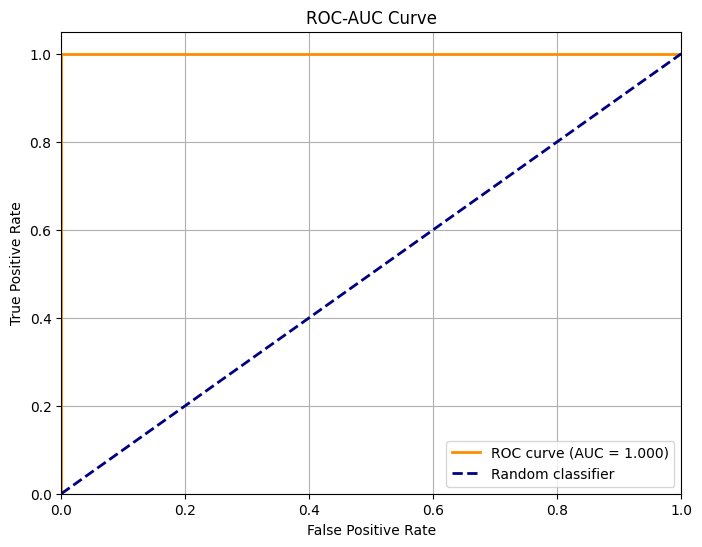

AUC Score: 1.000


In [94]:
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for ROC curve
y_pred_proba_model = model.predict(X_test_scaled_a)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_model)
model_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {model_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {model_roc_auc:.3f}")

<h5>Hyperparameter Tuning:

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

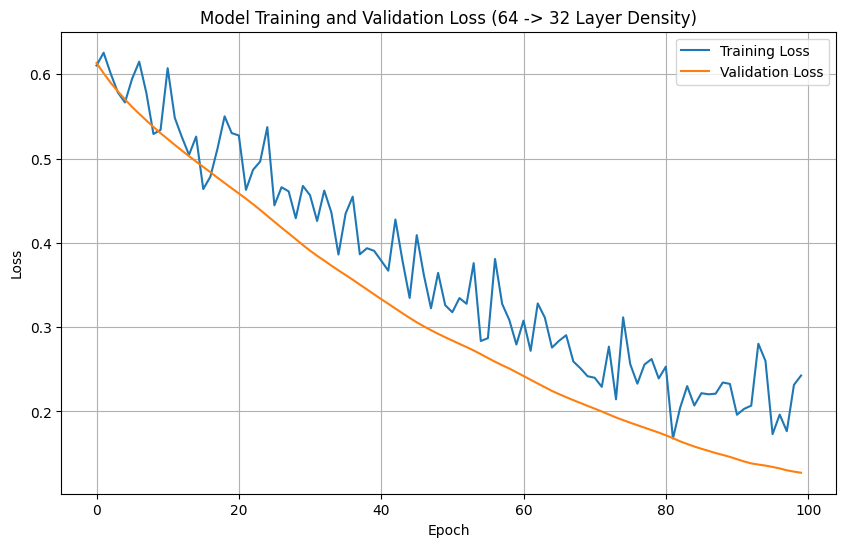

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

TensorFlow MLP Performance:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Confusion Matrix:
[[27  0]
 [ 0  9]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


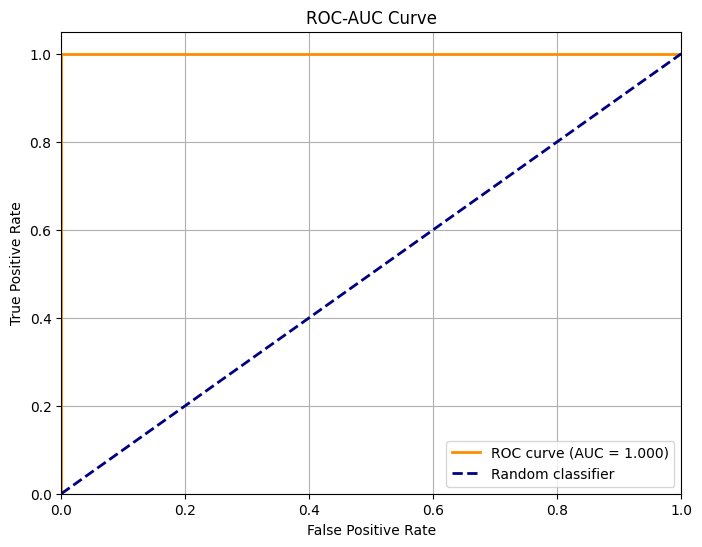

AUC Score: 1.000


In [95]:
# Changing layer density (64 -> 32)

t_model_1 = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled_a.shape[1],)), 
    layers.Dense(32, activation="relu"), 
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

t_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

t_model_1.summary() 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True
)

t_model_1_trained = t_model_1.fit(
    X_train_scaled_a, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0,
    shuffle = False
)

t_model_1_loss = t_model_1_trained.history['loss']
t_model_1_val_loss = t_model_1_trained.history['val_loss']

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(t_model_1_loss, label='Training Loss')
plt.plot(t_model_1_val_loss, label='Validation Loss')
plt.title('Model Training and Validation Loss (64 -> 32 Layer Density)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred_t_model_1 = (t_model_1.predict(X_test_scaled_a) > 0.5).astype(int)
print("\nTensorFlow MLP Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_t_model_1))
print("Classification Report:")
print(classification_report(y_test, y_pred_t_model_1))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_t_model_1))

y_pred_proba_t_model_1 = t_model_1.predict(X_test_scaled_a)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_t_model_1)
t_model_1_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {t_model_1_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {t_model_1_roc_auc:.3f}")

In [96]:
# Overfitting??

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,537 (37.25 KB)

 Non-trainable params: 0 (0.00 B)

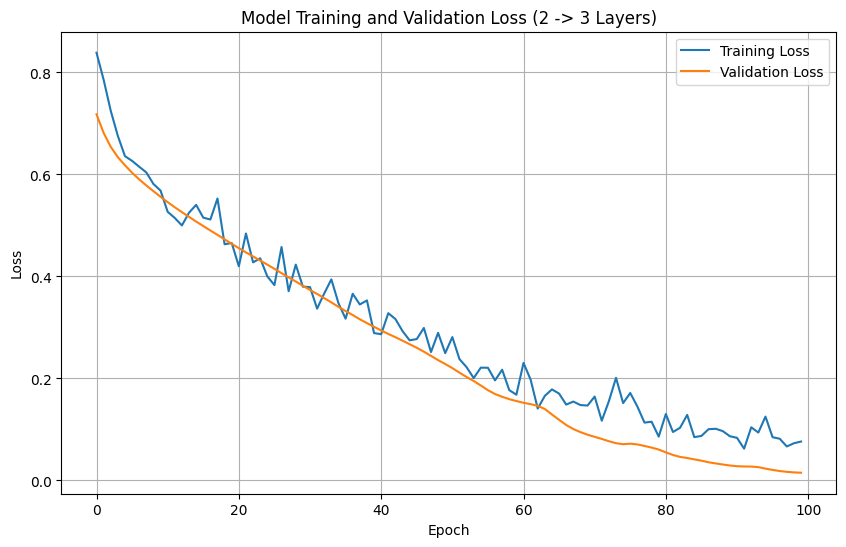

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

TensorFlow MLP Performance:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Confusion Matrix:
[[27  0]
 [ 0  9]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


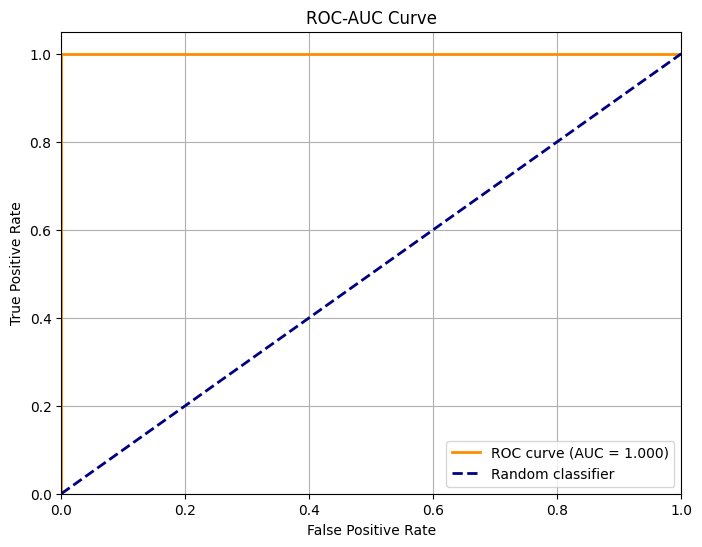

AUC Score: 1.000


In [97]:
# Changing ReLu layers (2 -> 3)

t_model_2 = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled_a.shape[1],)), 
    layers.Dense(64, activation="relu"), #1
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"), #2
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"), #3
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

t_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

t_model_2.summary() 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True
)

t_model_2_trained = t_model_2.fit(
    X_train_scaled_a, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0,
    shuffle = False
)

t_model_2_loss = t_model_2_trained.history['loss']
t_model_2_val_loss = t_model_2_trained.history['val_loss']

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(t_model_2_loss, label='Training Loss')
plt.plot(t_model_2_val_loss, label='Validation Loss')
plt.title('Model Training and Validation Loss (2 -> 3 Layers)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred_t_model_2 = (t_model_2.predict(X_test_scaled_a) > 0.5).astype(int)
print("\nTensorFlow MLP Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_t_model_2))
print("Classification Report:")
print(classification_report(y_test, y_pred_t_model_2))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_t_model_2))

y_pred_proba_t_model_2 = t_model_2.predict(X_test_scaled_a)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_t_model_2)
t_model_2_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {t_model_2_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {t_model_2_roc_auc:.3f}")

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 577 (2.25 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

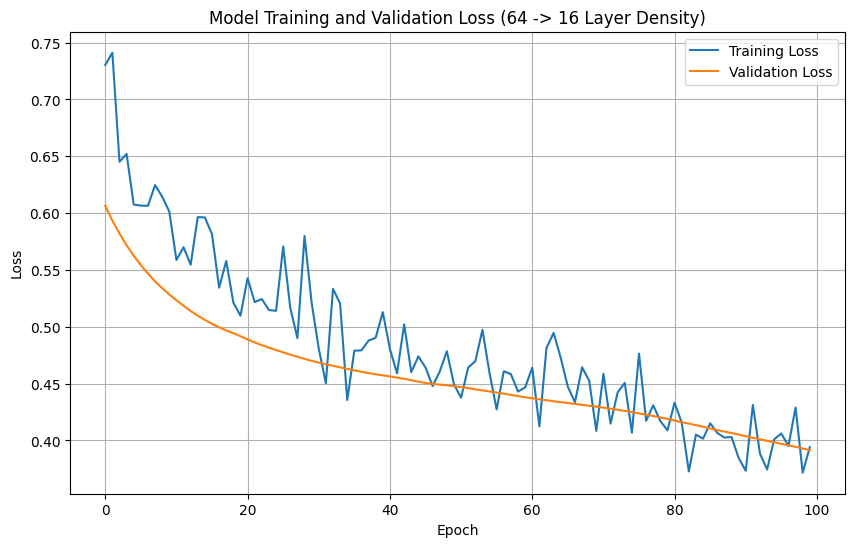

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

TensorFlow MLP Performance:
Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        27
           1       1.00      0.33      0.50         9

    accuracy                           0.83        36
   macro avg       0.91      0.67      0.70        36
weighted avg       0.86      0.83      0.80        36

Confusion Matrix:
[[27  0]
 [ 6  3]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


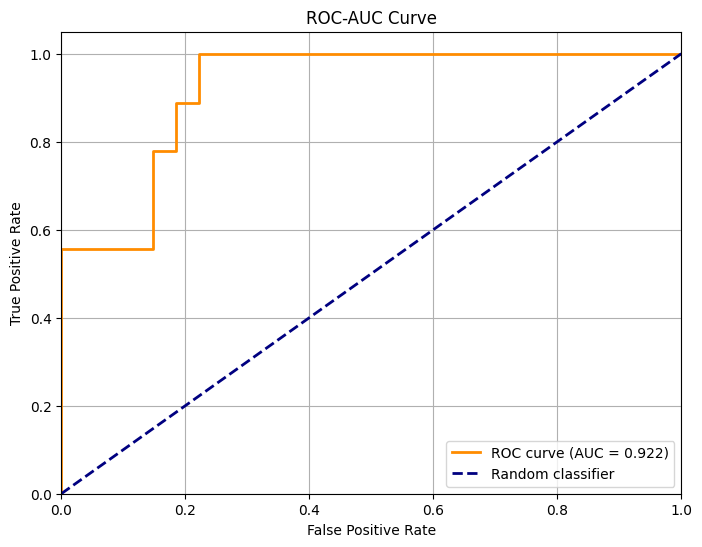

AUC Score: 0.922


In [98]:
# Changing layer density (64 -> 16)

t_model_3 = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled_a.shape[1],)), 
    layers.Dense(16, activation="relu"), 
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

t_model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

t_model_3.summary() 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True
)

t_model_3_trained = t_model_3.fit(
    X_train_scaled_a, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0,
    shuffle = False
)

t_model_3_loss = t_model_3_trained.history['loss']
t_model_3_val_loss = t_model_3_trained.history['val_loss']

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(t_model_3_loss, label='Training Loss')
plt.plot(t_model_3_val_loss, label='Validation Loss')
plt.title('Model Training and Validation Loss (64 -> 16 Layer Density)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred_t_model_3 = (t_model_3.predict(X_test_scaled_a) > 0.5).astype(int)
print("\nTensorFlow MLP Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_t_model_3))
print("Classification Report:")
print(classification_report(y_test, y_pred_t_model_3))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_t_model_3))

y_pred_proba_t_model_3 = t_model_3.predict(X_test_scaled_a)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_t_model_3)
t_model_3_roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {t_model_3_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {t_model_3_roc_auc:.3f}")

Model Performance Comparison:
                   Model  AUC Score  Accuracy  Final Training Loss  \
0  Original (64 neurons)     1.0000    1.0000               0.0710   
1             32 neurons     1.0000    1.0000               0.2426   
2               3 layers     1.0000    1.0000               0.0762   
3             16 neurons     0.9218    0.8333               0.3941   

   Final Validation Loss  
0                 0.0290  
1                 0.1273  
2                 0.0151  
3                 0.3916  


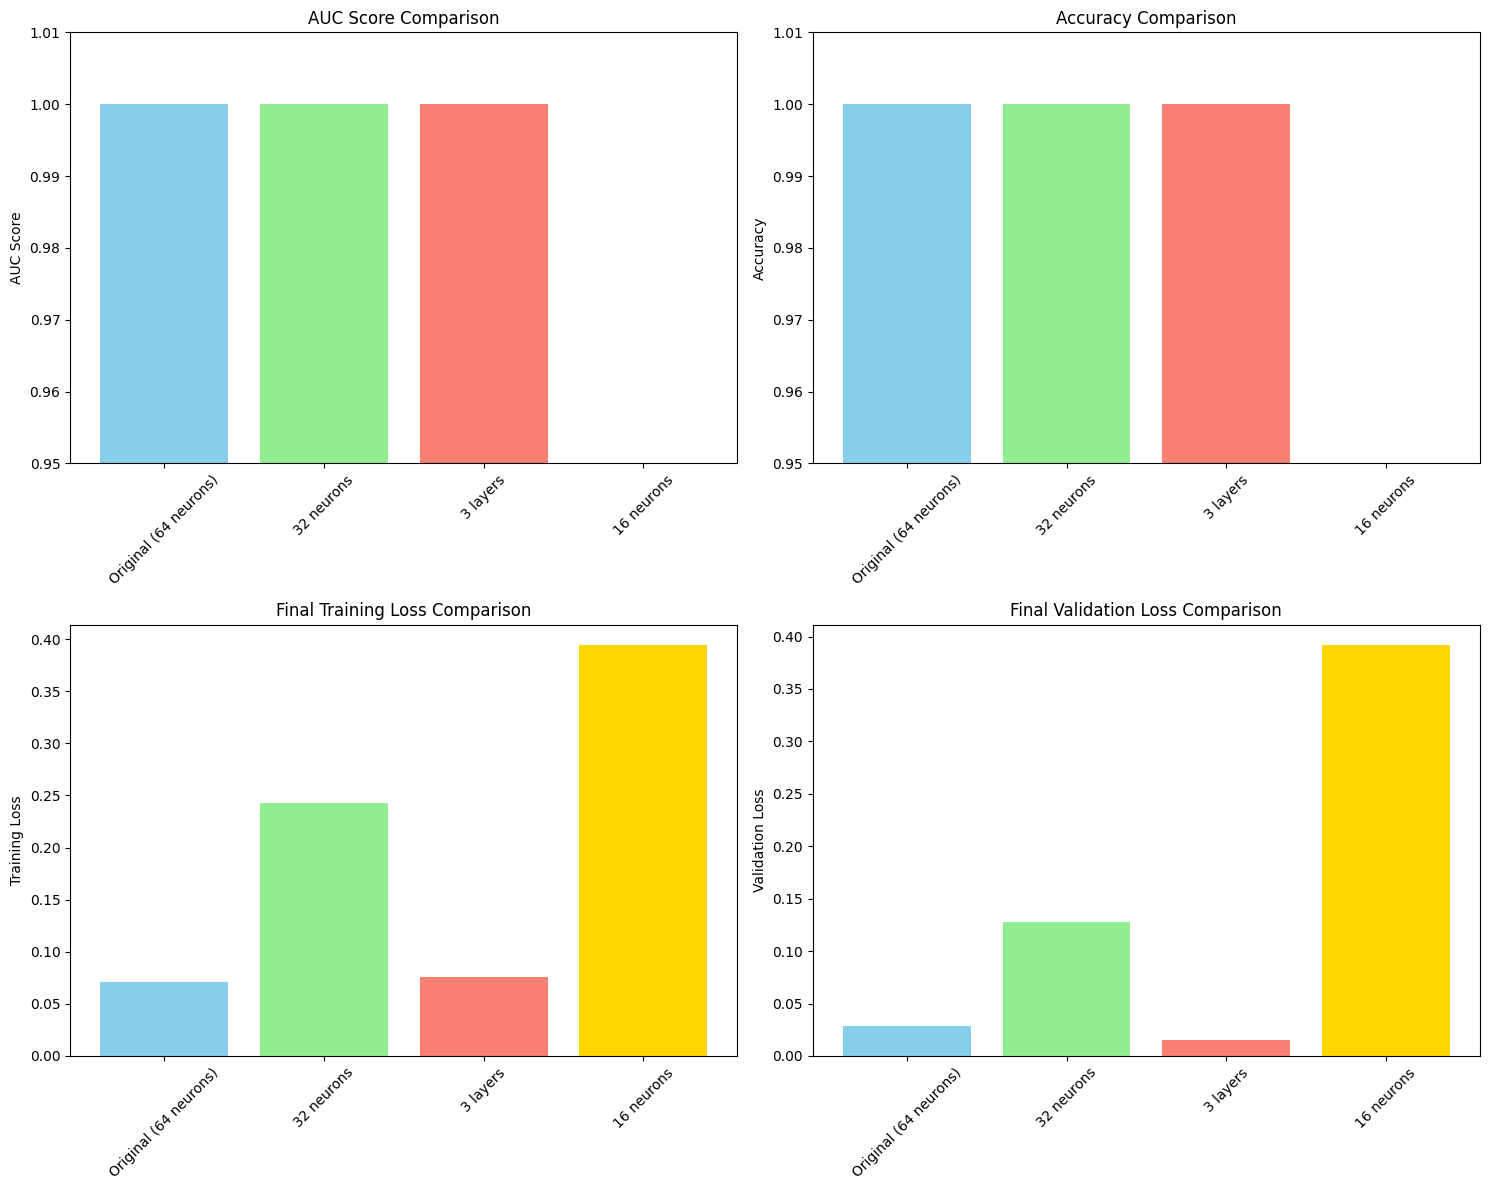

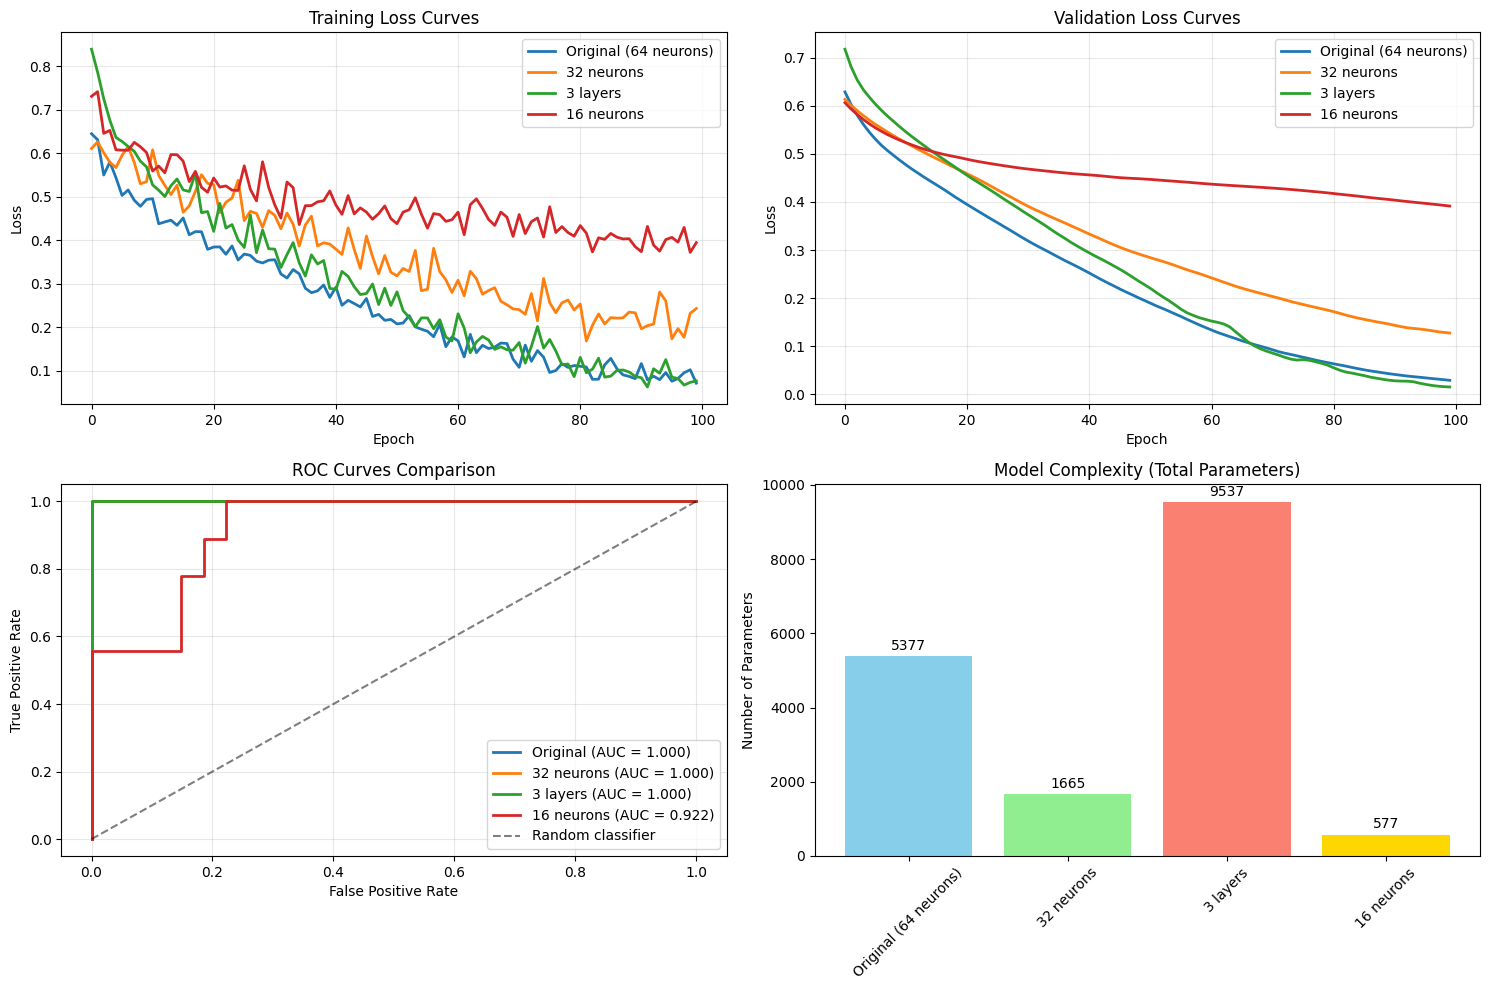

In [99]:
import numpy as np

# Create a comprehensive comparison of all models

# Collect all model performance metrics
models_comparison = {
    'Model': ['Original (64 neurons)', '32 neurons', '3 layers', '16 neurons'],
    'AUC Score': [model_roc_auc, t_model_1_roc_auc, t_model_2_roc_auc, t_model_3_roc_auc],
    'Accuracy': [
        accuracy_score(y_test, y_pred_model),
        accuracy_score(y_test, y_pred_t_model_1),
        accuracy_score(y_test, y_pred_t_model_2),
        accuracy_score(y_test, y_pred_t_model_3)
    ],
    'Final Training Loss': [
        model_loss[-1],
        t_model_1_loss[-1],
        t_model_2_loss[-1],
        t_model_3_loss[-1]
    ],
    'Final Validation Loss': [
        model_val_loss[-1],
        t_model_1_val_loss[-1],
        t_model_2_val_loss[-1],
        t_model_3_val_loss[-1]
    ]
}

# Create comparison dataframe
comparison_df = pd.DataFrame(models_comparison)
print("Model Performance Comparison:")
print(comparison_df.round(4))

# Plot comparison charts
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# AUC Score comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['AUC Score'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 0].set_title('AUC Score Comparison')
axes[0, 0].set_ylabel('AUC Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(0.95, 1.01)

# Accuracy comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 1].set_title('Accuracy Comparison')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0.95, 1.01)

# Training Loss comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['Final Training Loss'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1, 0].set_title('Final Training Loss Comparison')
axes[1, 0].set_ylabel('Training Loss')
axes[1, 0].tick_params(axis='x', rotation=45)

# Validation Loss comparison
axes[1, 1].bar(comparison_df['Model'], comparison_df['Final Validation Loss'], color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1, 1].set_title('Final Validation Loss Comparison')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot all training curves together
plt.figure(figsize=(15, 10))

# Training loss curves
plt.subplot(2, 2, 1)
plt.plot(model_loss, label='Original (64 neurons)', linewidth=2)
plt.plot(t_model_1_loss, label='32 neurons', linewidth=2)
plt.plot(t_model_2_loss, label='3 layers', linewidth=2)
plt.plot(t_model_3_loss, label='16 neurons', linewidth=2)
plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation loss curves
plt.subplot(2, 2, 2)
plt.plot(model_val_loss, label='Original (64 neurons)', linewidth=2)
plt.plot(t_model_1_val_loss, label='32 neurons', linewidth=2)
plt.plot(t_model_2_val_loss, label='3 layers', linewidth=2)
plt.plot(t_model_3_val_loss, label='16 neurons', linewidth=2)
plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# ROC curves comparison
plt.subplot(2, 2, 3)
# Calculate ROC for all models
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_pred_proba_model)
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_proba_t_model_1)
fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_proba_t_model_2)
fpr_3, tpr_3, _ = roc_curve(y_test, y_pred_proba_t_model_3)

plt.plot(fpr_orig, tpr_orig, label=f'Original (AUC = {model_roc_auc:.3f})', linewidth=2)
plt.plot(fpr_1, tpr_1, label=f'32 neurons (AUC = {t_model_1_roc_auc:.3f})', linewidth=2)
plt.plot(fpr_2, tpr_2, label=f'3 layers (AUC = {t_model_2_roc_auc:.3f})', linewidth=2)
plt.plot(fpr_3, tpr_3, label=f'16 neurons (AUC = {t_model_3_roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random classifier')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# Model complexity comparison
plt.subplot(2, 2, 4)
model_params = [
    model.count_params(),
    t_model_1.count_params(),
    t_model_2.count_params(),
    t_model_3.count_params()
]
bars = plt.bar(comparison_df['Model'], model_params, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title('Model Complexity (Total Parameters)')
plt.ylabel('Number of Parameters')
plt.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, param in zip(bars, model_params):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(model_params)*0.01, 
             str(param), ha='center', va='bottom')

plt.tight_layout()
plt.show()